In [ ]:
import torch
from torch import nn, optim
# !pip install jcopdl==1.1.1
from jcopdl.callback import Callback, set_config
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import os
os.makedirs('models', exist_ok=True)
# !git clone https://github.com/WiraDKP/deep_learning.git content/deep_learning
import warnings
import multiprocessing
warnings.filterwarnings("ignore")
multiprocessing.set_start_method('fork', force=True)

In [ ]:
# import zipfile
# import io

# zip1 = '/content/content/deep_learning/13 - Neural Network/data.zip'

# with zipfile.ZipFile(zip1, 'r') as zip_ref:
#     zip_ref.extractall('/content/') # Ekstrak ke direktori /content/

# print(f"File {zip1} berhasil diekstrak ke /content/")
# !ls /content/my_folder # Verifikasi

# dataset dan dataloader

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
bs = 256
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()

])


trainset = datasets.ImageFolder('/content/data/train',
                                transform=transform)
trainloader = DataLoader(trainset, batch_size=bs, shuffle=True, num_workers=4)


testset = datasets.ImageFolder('/content/data/test',
                               transform=transform)
testloader = DataLoader(testset, batch_size=bs, shuffle=False, num_workers=4)
trainset

Dataset ImageFolder
    Number of datapoints: 40000
    Root location: /content/data/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )

In [ ]:
images, labels = next(iter(trainloader))
images.shape, labels.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [ ]:
trainset.classes

['Ankle boot',
 'Bag',
 'Coat',
 'Dress',
 'Pullover',
 'Sandal',
 'Shirt',
 'Sneaker',
 'T-shirt or Top',
 'Trouser']

# arsitektur dan config

In [ ]:
from torch.nn import BatchNorm1d

In [ ]:
def linear_block(in_features, out_features, activation='relu', dropout=0.0):
    layers = [nn.Linear(in_features, out_features)]
    # if batch_norm:
    #     layers.append(BatchNorm1d(out_features))
    if activation == 'relu':
        layers.append(nn.ReLU())
    elif activation == 'sigmoid':
        layers.append(nn.Sigmoid())
    elif activation == 'tanh':
        layers.append(nn.Tanh())
    if dropout > 0.0:
        layers.append(nn.Dropout(dropout))
    return nn.Sequential(*layers)

In [ ]:
class FashionClassifier(nn.Module):
    def __init__(self, input_size=1 * 28 * 28, output_size=10, dropout=0.2):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            linear_block(input_size, 512, activation='relu', dropout=dropout),
            linear_block(512, 256,  activation='relu', dropout=dropout),
            linear_block(256, 128,  activation='relu', dropout=dropout),
            linear_block(128, 64,  activation='relu', dropout=dropout),
            linear_block(64, 32,  activation='relu', dropout=dropout),
            nn.Linear(32, output_size),
            nn.LogSoftmax()
            )
    def forward(self, x):
        return self.fc(x)

In [ ]:
condfig = set_config({
    'input_size':1 * 28 * 28,
    'n2':256,
    'n3':128,
    'n4':64,
    'output_size':len(trainset.classes),
    'dropout':0.2})

In [ ]:
model = FashionClassifier().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
callback = Callback(model=model, outdir='models')

# Train

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    from tqdm.auto import tqdm
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(dim=1) == target).sum().item()
    cost = cost / len(dataset)
    accuracy = correct / len(dataset)
    return cost, accuracy

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 1.0793 | Test_cost  = 0.5438 | Train_score = 0.5941 | Test_score = 0.7916 |
Train Cost: 1.0793, Test Cost: 0.5438


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
Exception ignored in:     self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        
self._shutdown_workers()Traceback (most recent call last):
if w.is_alive():

  Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
  File "/usr/local/lib/python3.1

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.5992 | Test_cost  = 0.4642 | Train_score = 0.7877 | Test_score = 0.8289 |
Train Cost: 0.5992, Test Cost: 0.4642


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.4959 | Test_cost  = 0.4248 | Train_score = 0.8304 | Test_score = 0.8431 |
Train Cost: 0.4959, Test Cost: 0.4248


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.4522 | Test_cost  = 0.3806 | Train_score = 0.8450 | Test_score = 0.8662 |
Train Cost: 0.4522, Test Cost: 0.3806


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.4143 | Test_cost  = 0.4164 | Train_score = 0.8587 | Test_score = 0.8516 |
==> EarlyStop patience =  1 | Best test_score: 0.8662
Train Cost: 0.4143, Test Cost: 0.4164


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
   Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80> 
   Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^^if w.is_alive():^
  ^ ^^ ^ ^ ^ ^^^^^^^^^^^^


Epoch     6
Train_cost  = 0.4115 | Test_cost  = 0.3850 | Train_score = 0.8592 | Test_score = 0.8619 |
==> EarlyStop patience =  2 | Best test_score: 0.8662
Train Cost: 0.4115, Test Cost: 0.3850


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>self._shutdown_workers()
Exception ignored in: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
        
self._shutdown_workers()
Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80><function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
            self._shutdown_workers()self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():

 self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in 


Epoch     7
Train_cost  = 0.3896 | Test_cost  = 0.3704 | Train_score = 0.8666 | Test_score = 0.8699 |
Train Cost: 0.3896, Test Cost: 0.3704


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.3661 | Test_cost  = 0.3574 | Train_score = 0.8756 | Test_score = 0.8718 |
Train Cost: 0.3661, Test Cost: 0.3574


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.3583 | Test_cost  = 0.3632 | Train_score = 0.8772 | Test_score = 0.8731 |
Train Cost: 0.3583, Test Cost: 0.3632


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.3450 | Test_cost  = 0.3369 | Train_score = 0.8822 | Test_score = 0.8810 |
Train Cost: 0.3450, Test Cost: 0.3369


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3357 | Test_cost  = 0.3354 | Train_score = 0.8852 | Test_score = 0.8840 |
Train Cost: 0.3357, Test Cost: 0.3354


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3257 | Test_cost  = 0.3569 | Train_score = 0.8895 | Test_score = 0.8710 |
==> EarlyStop patience =  1 | Best test_score: 0.8840
Train Cost: 0.3257, Test Cost: 0.3569


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Exception ignored in: self._shutdown_workers()
 <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: 
 <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>    Traceback (most recent call last):
 if w.is_alive():  

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    if w.is_alive():
 self._shutdown_workers()
     self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, i


Epoch    13
Train_cost  = 0.3197 | Test_cost  = 0.3403 | Train_score = 0.8879 | Test_score = 0.8786 |
==> EarlyStop patience =  2 | Best test_score: 0.8840
Train Cost: 0.3197, Test Cost: 0.3403


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3147 | Test_cost  = 0.3535 | Train_score = 0.8920 | Test_score = 0.8747 |
==> EarlyStop patience =  3 | Best test_score: 0.8840
Train Cost: 0.3147, Test Cost: 0.3535


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3109 | Test_cost  = 0.3315 | Train_score = 0.8914 | Test_score = 0.8854 |
Train Cost: 0.3109, Test Cost: 0.3315


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3001 | Test_cost  = 0.3371 | Train_score = 0.8955 | Test_score = 0.8810 |
==> EarlyStop patience =  1 | Best test_score: 0.8854
Train Cost: 0.3001, Test Cost: 0.3371


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.2986 | Test_cost  = 0.3293 | Train_score = 0.8978 | Test_score = 0.8865 |
Train Cost: 0.2986, Test Cost: 0.3293


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.2914 | Test_cost  = 0.3307 | Train_score = 0.8978 | Test_score = 0.8843 |
==> EarlyStop patience =  1 | Best test_score: 0.8865
Train Cost: 0.2914, Test Cost: 0.3307


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>    
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():if w.is_alive():
     
         ^^^^^^^^^Exception ignored in: Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80><function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>^
^Traceback (m

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.2825 | Test_cost  = 0.3198 | Train_score = 0.9005 | Test_score = 0.8889 |
Train Cost: 0.2825, Test Cost: 0.3198


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.2754 | Test_cost  = 0.3293 | Train_score = 0.9033 | Test_score = 0.8870 |


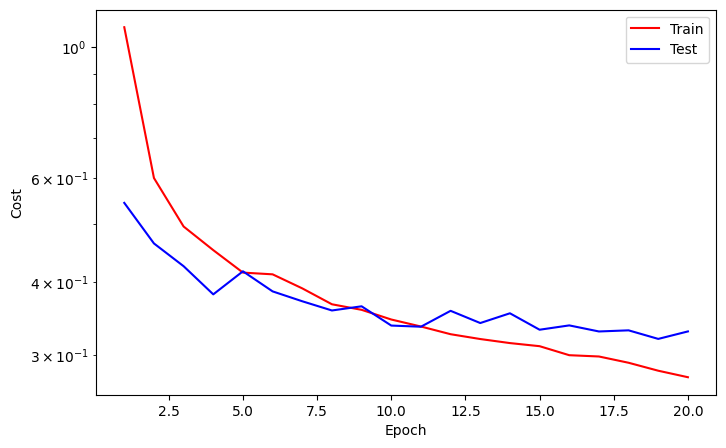

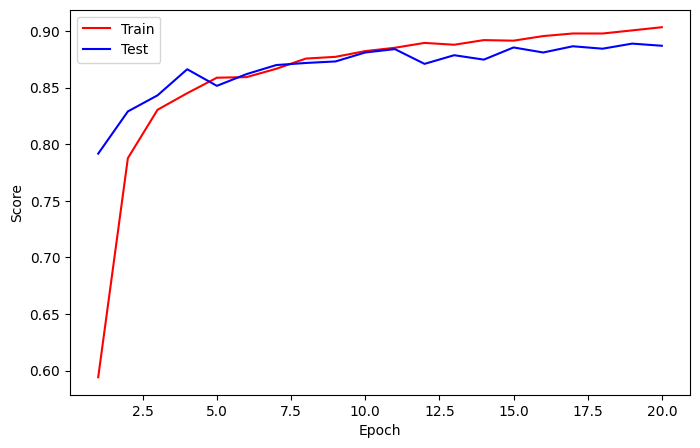

==> EarlyStop patience =  1 | Best test_score: 0.8889
Train Cost: 0.2754, Test Cost: 0.3293


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.2777 | Test_cost  = 0.3319 | Train_score = 0.9025 | Test_score = 0.8843 |
==> EarlyStop patience =  2 | Best test_score: 0.8889
Train Cost: 0.2777, Test Cost: 0.3319


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.2689 | Test_cost  = 0.3272 | Train_score = 0.9061 | Test_score = 0.8871 |
==> EarlyStop patience =  3 | Best test_score: 0.8889
Train Cost: 0.2689, Test Cost: 0.3272


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.2666 | Test_cost  = 0.3256 | Train_score = 0.9058 | Test_score = 0.8869 |
==> EarlyStop patience =  4 | Best test_score: 0.8889
Train Cost: 0.2666, Test Cost: 0.3256


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>    self._shutdown_workers()
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():    
if w.is_alive(): 
             ^^^^^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
        assert self.

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
self._shutdown_workers()        self._shutdown_workers()self._shutdown_workers()
Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown


Epoch    24
Train_cost  = 0.2609 | Test_cost  = 0.3251 | Train_score = 0.9071 | Test_score = 0.8893 |
Train Cost: 0.2609, Test Cost: 0.3251


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.2552 | Test_cost  = 0.3387 | Train_score = 0.9120 | Test_score = 0.8862 |
==> EarlyStop patience =  1 | Best test_score: 0.8893
Train Cost: 0.2552, Test Cost: 0.3387


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.2504 | Test_cost  = 0.3322 | Train_score = 0.9112 | Test_score = 0.8878 |
==> EarlyStop patience =  2 | Best test_score: 0.8893
Train Cost: 0.2504, Test Cost: 0.3322


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2461 | Test_cost  = 0.3258 | Train_score = 0.9135 | Test_score = 0.8908 |
Train Cost: 0.2461, Test Cost: 0.3258


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2538 | Test_cost  = 0.3235 | Train_score = 0.9117 | Test_score = 0.8898 |
==> EarlyStop patience =  1 | Best test_score: 0.8908
Train Cost: 0.2538, Test Cost: 0.3235


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2432 | Test_cost  = 0.3213 | Train_score = 0.9133 | Test_score = 0.8898 |
==> EarlyStop patience =  2 | Best test_score: 0.8908
Train Cost: 0.2432, Test Cost: 0.3213


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>

 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
      self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
     ^if w.is_alive():^
^ ^  ^ ^^   ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self.

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2400 | Test_cost  = 0.3256 | Train_score = 0.9161 | Test_score = 0.8929 |
Train Cost: 0.2400, Test Cost: 0.3256


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.2387 | Test_cost  = 0.3249 | Train_score = 0.9149 | Test_score = 0.8882 |
==> EarlyStop patience =  1 | Best test_score: 0.8929
Train Cost: 0.2387, Test Cost: 0.3249


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2290 | Test_cost  = 0.3457 | Train_score = 0.9175 | Test_score = 0.8892 |
==> EarlyStop patience =  2 | Best test_score: 0.8929
Train Cost: 0.2290, Test Cost: 0.3457


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.2315 | Test_cost  = 0.3403 | Train_score = 0.9167 | Test_score = 0.8918 |
==> EarlyStop patience =  3 | Best test_score: 0.8929
Train Cost: 0.2315, Test Cost: 0.3403


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Test:   0%|          | 0/79 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2245 | Test_cost  = 0.3341 | Train_score = 0.9193 | Test_score = 0.8891 |
==> EarlyStop patience =  4 | Best test_score: 0.8929
Train Cost: 0.2245, Test Cost: 0.3341


Train:   0%|          | 0/157 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
if w.is_alive():    
   self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
      if w.is_alive():  
^ ^ ^ ^  ^ ^ ^^^^^^^^^^^
^  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a child process'
^ ^ ^ 
   File "/usr/lib/py

Test:   0%|          | 0/79 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Exception ignored in: 
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>
<function _MultiProcessingDataLoaderIter.__del__ at 0x79c2a0527d80>Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, 


Epoch    35
Train_cost  = 0.2184 | Test_cost  = 0.3338 | Train_score = 0.9229 | Test_score = 0.8912 |
==> EarlyStop patience =  5 | Best test_score: 0.8929
==> Execute Early Stopping at epoch: 35 | Best test_score: 0.8929
==> Best model is saved at models
Early stopping triggered.


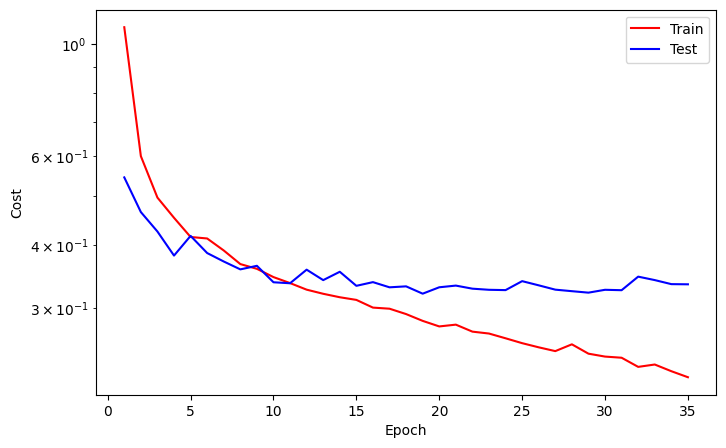

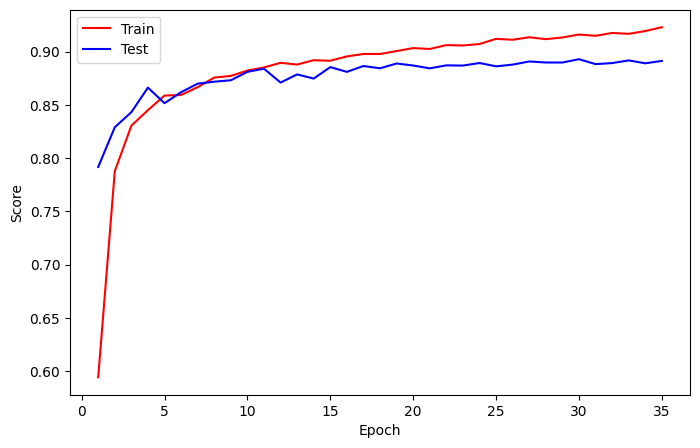

In [ ]:
while True:
    train_cost, train_acc = loop_fn('train', trainset, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost, test_acc = loop_fn('test', testset, testloader, model, criterion, optimizer, device)

    callback.log(train_cost=train_cost, test_cost=test_cost, test_score=test_acc, train_score=train_acc)
    callback.save_checkpoint()
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()
    if callback.early_stopping(model, monitor='test_score', load_best_when_stop=True):
        print("Early stopping triggered.")
        callback.plot_cost()
        callback.plot_score()
        break





    print(f'Train Cost: {train_cost:.4f}, Test Cost: {test_cost:.4f}')

In [ ]:
weight = torch.load('models/weights_best.pth', map_location='cpu')
model = FashionClassifier().to(device)
model.load_state_dict(weight)

<All keys matched successfully>

In [ ]:
feature, target = next(iter(trainloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
label2cat = trainset.classes

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(dim=1)

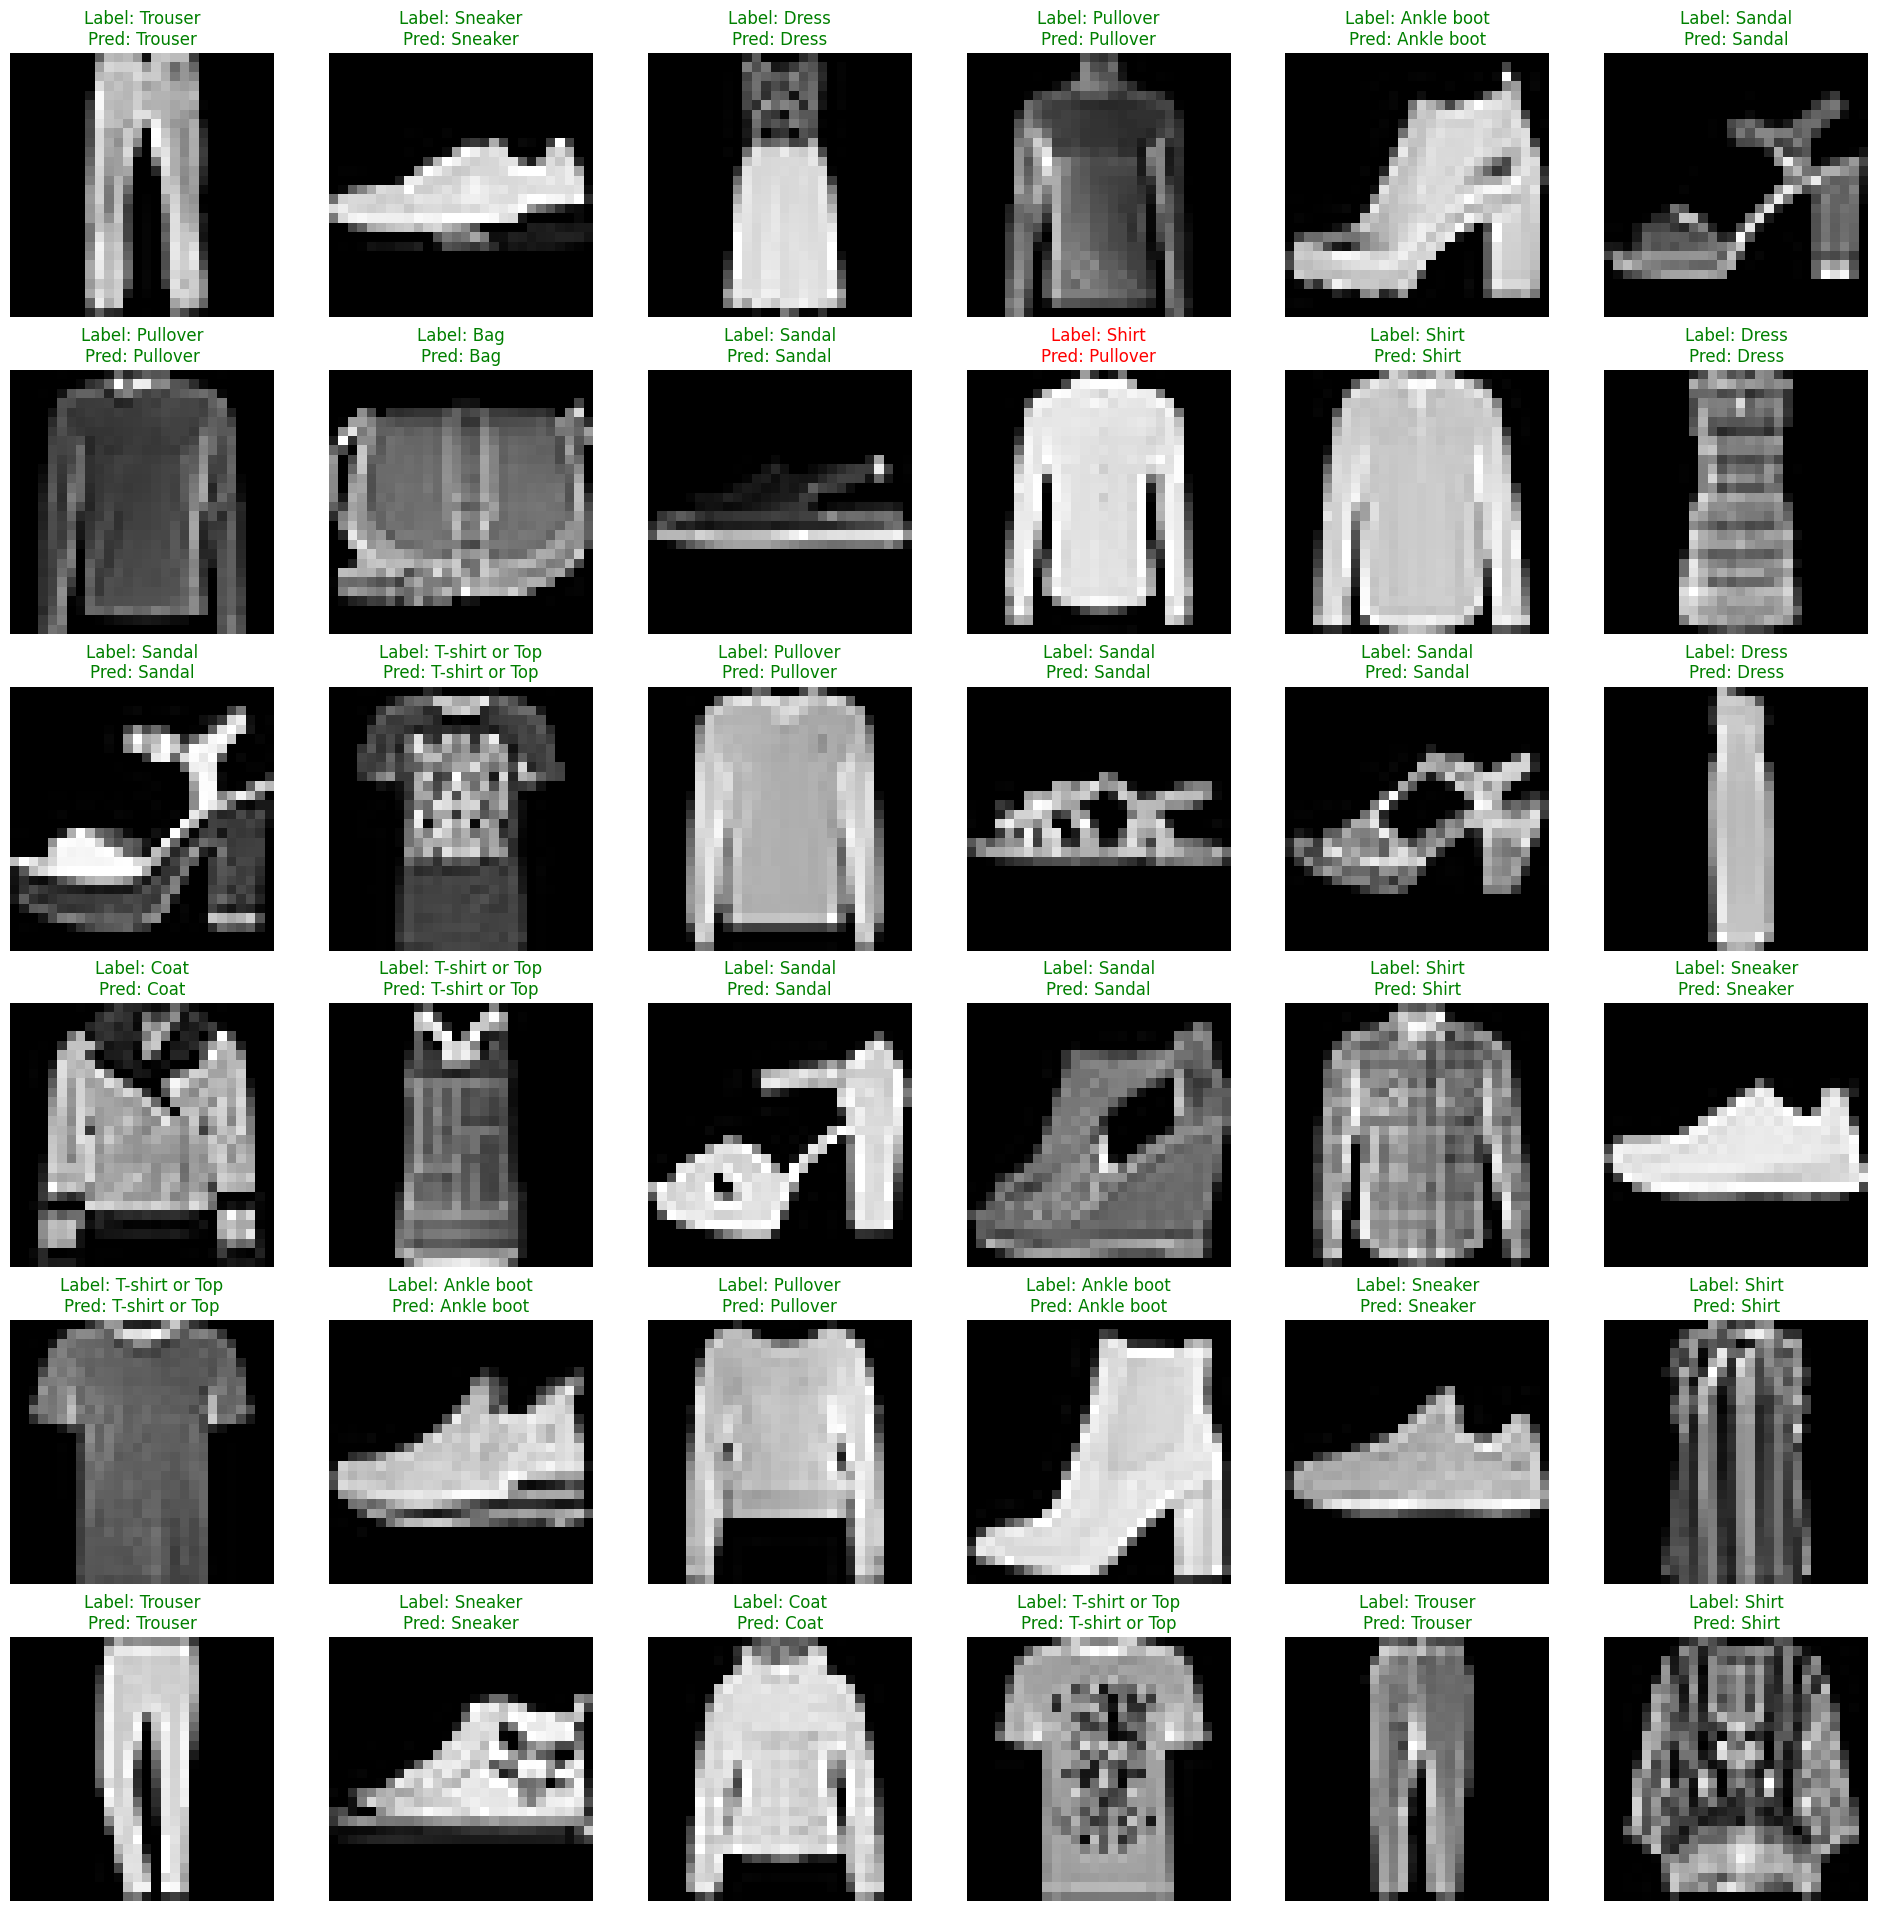

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
fig, axes = plt.subplots(6,6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.cpu().view(28,28), cmap='gray')
    font = {'color': 'r'} if label != pred else {'color':'g'}
    label_text, pred_text = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label_text}\nPred: {pred_text}', fontdict=font)
    ax.axis('off');